# Data Exploration of H-MOG Dataset

*Created by Holger Buech, Q1/2019*

**Description**   

Basic statistics & visualizations for the H-MOG Dataset, especially considering aggregation on sessions and subjects.

**Purpose**
- Get basic understanding of dataset
- Check for completeness
- Inspect data distribution

**Data Sources**   
- [H-MOG Dataset](http://www.cs.wm.edu/~qyang/hmog.html)  
  (Downloaded beforehand using  [./src/data/make_dataset.py](./src/data/make_dataset.py), stored in [./data/external/hmog_dataset/](./data/external/hmog_dataset/) and converted to [./data/processed/hmog_dataset.hdf5](./data/processed/hmog_dataset.hdf5))

## Preparations

### Imports

In [1]:
# Standard
from pathlib import Path
import os
import sys
import datetime

# Extra
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.style as style
import seaborn as sns

# `DatasetLoader` is a custom helper class to retrieve data from hdf5 file
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utility.dataset_loader_hdf5 import DatasetLoader

In [2]:
%matplotlib inline
%run utils.ipynb
utils_set_output_style()

### Configuration

In [3]:
# Various Settings
TABLE_NAME = "sensors_100hz"  # Table with raw sensor data
HMOG_HDF5 = Path.cwd().parent / "data" / "processed" / "hmog_dataset.hdf5"
SEED = 712

FEATURE_COLS = [
    "acc_x",
    "acc_y",
    "acc_z",
]

REPORT_PATH = Path.cwd().parent / "reports" / "figures"  # Figures for thesis
REPORT_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
hmog = DatasetLoader(
    hdf5_file=HMOG_HDF5,
    table_name=TABLE_NAME,
    max_subjects=None,
    task_types=[],
    exclude_subjects=[],   
    exclude_cols=[],
    seed=SEED,
)
hmog.data_summary()

,DataFrame,Memory (MB),Rows,Columns,Subjects,Sessions
0,all,7567.67,123988689,7,100,2392
1,index,0.09,2392,4,100,2392


## Exploration

### Basics

In [5]:
hmog.all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123988689 entries, 0 to 30717
Data columns (total 7 columns):
acc_x        float64
acc_y        float64
acc_z        float64
sys_time     int64
subject      object
session      object
task_type    int64
dtypes: float64(3), int64(2), object(2)
memory usage: 7.4+ GB


In [6]:
hmog.all.head()

,acc_x,acc_y,acc_z,sys_time,subject,session,task_type
0,-0.585981,4.196437,7.703344,1400284020080,277905,277905_session_24,6
1,-0.004788,3.712210,7.844602,1400284020090,277905,277905_session_24,6
2,-0.314239,4.866814,7.767389,1400284020100,277905,277905_session_24,6
3,-0.497597,4.911107,7.731974,1400284020110,277905,277905_session_24,6
4,-0.680951,4.955399,7.696560,1400284020120,277905,277905_session_24,6


In [7]:
hmog.all.describe(include="all", percentiles=[])

,acc_x,acc_y,acc_z,sys_time,subject,session,task_type
count,1.239887e+08,1.239887e+08,1.239887e+08,1.239887e+08,123988689,123988689,1.239887e+08
unique,NaN,NaN,NaN,NaN,100,2392,NaN
top,NaN,NaN,NaN,NaN,256487,771782_session_5,NaN
freq,NaN,NaN,NaN,NaN,2326802,224813,NaN
mean,1.753539e-01,4.671558e+00,7.644926e+00,1.399221e+12,NaN,NaN,3.363734e+00
std,1.866522e+00,2.162493e+00,1.365952e+00,1.814998e+09,NaN,NaN,1.683104e+00
min,-1.960911e+01,-1.958756e+01,-1.960851e+01,1.396222e+12,NaN,NaN,0.000000e+00
50%,-1.653495e-02,4.914083e+00,7.797293e+00,1.399418e+12,NaN,NaN,3.000000e+00
max,1.960791e+01,1.814266e+01,1.960851e+01,1.402767e+12,NaN,NaN,6.000000e+00


In [8]:
hmog.all.isna().sum()

acc_x        0
acc_y        0
acc_z        0
sys_time     0
subject      0
session      0
task_type    0
dtype: int64

In [9]:
# Cast subjects to categorical for plotting & memory saving
hmog.all["subject"] = hmog.all["subject"].astype("category")

**Interpretation:**

- All data types look correct
- Ranges for sensordata seem reasonable
- No missing values

### Example Session

In [10]:
np.random.seed(SEED)
session = np.random.choice(hmog.all["session"].unique())
session

'240168_session_6'

In [11]:
df_single_session = hmog.all[hmog.all["session"] == session].copy()
df_single_session["Session Time"] = pd.to_datetime(df_single_session['sys_time'], unit='ms')
df_single_session = df_single_session.set_index("Session Time")
df_single_session.head()

,acc_x,acc_y,acc_z,sys_time,subject,session,task_type
Session Time,,,,,,,
2014-05-07 01:12:17.760,-1.077391,5.659893,6.297947,1399425137760,240168,240168_session_6,3
2014-05-07 01:12:17.770,-0.994139,5.666150,6.324555,1399425137770,240168,240168_session_6,3
2014-05-07 01:12:17.780,-0.910885,5.672408,6.351164,1399425137780,240168,240168_session_6,3
2014-05-07 01:12:17.790,-0.827631,5.678666,6.377773,1399425137790,240168,240168_session_6,3
2014-05-07 01:12:17.800,-0.744379,5.684923,6.404380,1399425137800,240168,240168_session_6,3


In [12]:
print("Session duration according to timestamps:")
df_single_session.index.max() - df_single_session.index.min()

Session duration according to timestamps:


Timedelta('0 days 00:10:51.980000')

In [13]:
print("Session duration value count & frequency:")
sec = datetime.timedelta(seconds=len(df_single_session) / 100)
str(sec)

Session duration value count & frequency:


'0:10:51.990000'

In [14]:
print(f"Task Type: {int(df_single_session.task_type.unique()[0])}")
print("where\n[1, 3, 5] are sitting \n[2, 4, 6] are walking")

Task Type: 3
where
[1, 3, 5] are sitting 
[2, 4, 6] are walking


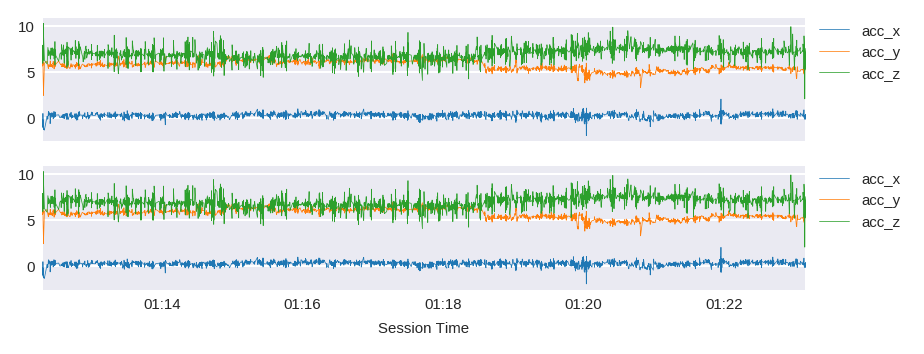

In [52]:
plot_rows = [
    ["acc_x", "acc_y", "acc_z"],
    ["acc_x", "acc_y", "acc_z"],
]

f, axes = plt.subplots(2, 1, dpi=180, figsize=(5.473, 2))
for i, row in enumerate(plot_rows):
    g = df_single_session[row].plot(linewidth=0.3, ax=axes[i], sharex="col")
    g.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.0)
  
utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-session-sample.png")

### Overall Sensor Data Distribution

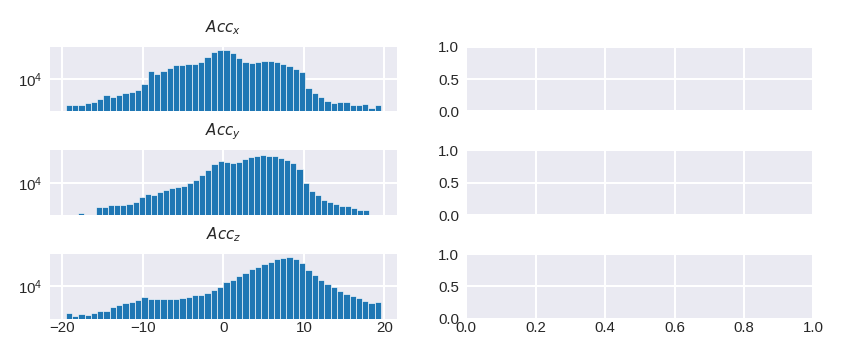

In [55]:
df_temp = hmog.all[FEATURE_COLS]
df_temp.columns = ["$" + c.capitalize()  + "$" for c in df_temp.columns]

f, axes = plt.subplots(3, 2, sharex="col", sharey="col", dpi=180, figsize=(5.473, 2))
f.subplots_adjust(hspace=0.6, wspace=0.2)
cmap = cm.get_cmap("tab10")

for i, col in enumerate(df_temp.columns):
    plot_column = int(i // 3)
    plot_row = i - plot_column * 3

    g = sns.distplot(
        df_temp[col],
        kde=False,
        ax=axes[plot_row][plot_column],
        color=cmap(plot_column),
        hist_kws=dict(alpha=1),
    )
    g.set_title(f"{col}")
    g.set_yscale("log")
    g.axes.set_xlabel("")

utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-sensor-distribution.png")

**Interpretation:**

- The distributions vary a lot from sensor to sensor
- Accelerometer: Left skewed y- and z-axis. Probably towards 10 because of gravity component. Less skewness in x-axis, which is Platykurtic.
- Gyroscope: very smooth, probably close to normal. Only x-axis is slightly left skewed
- Magnetometer: Strong skewness in all axis. z-axis has some massive outliers.

### Distribution per Subjects

**Sensor Data Distribution**

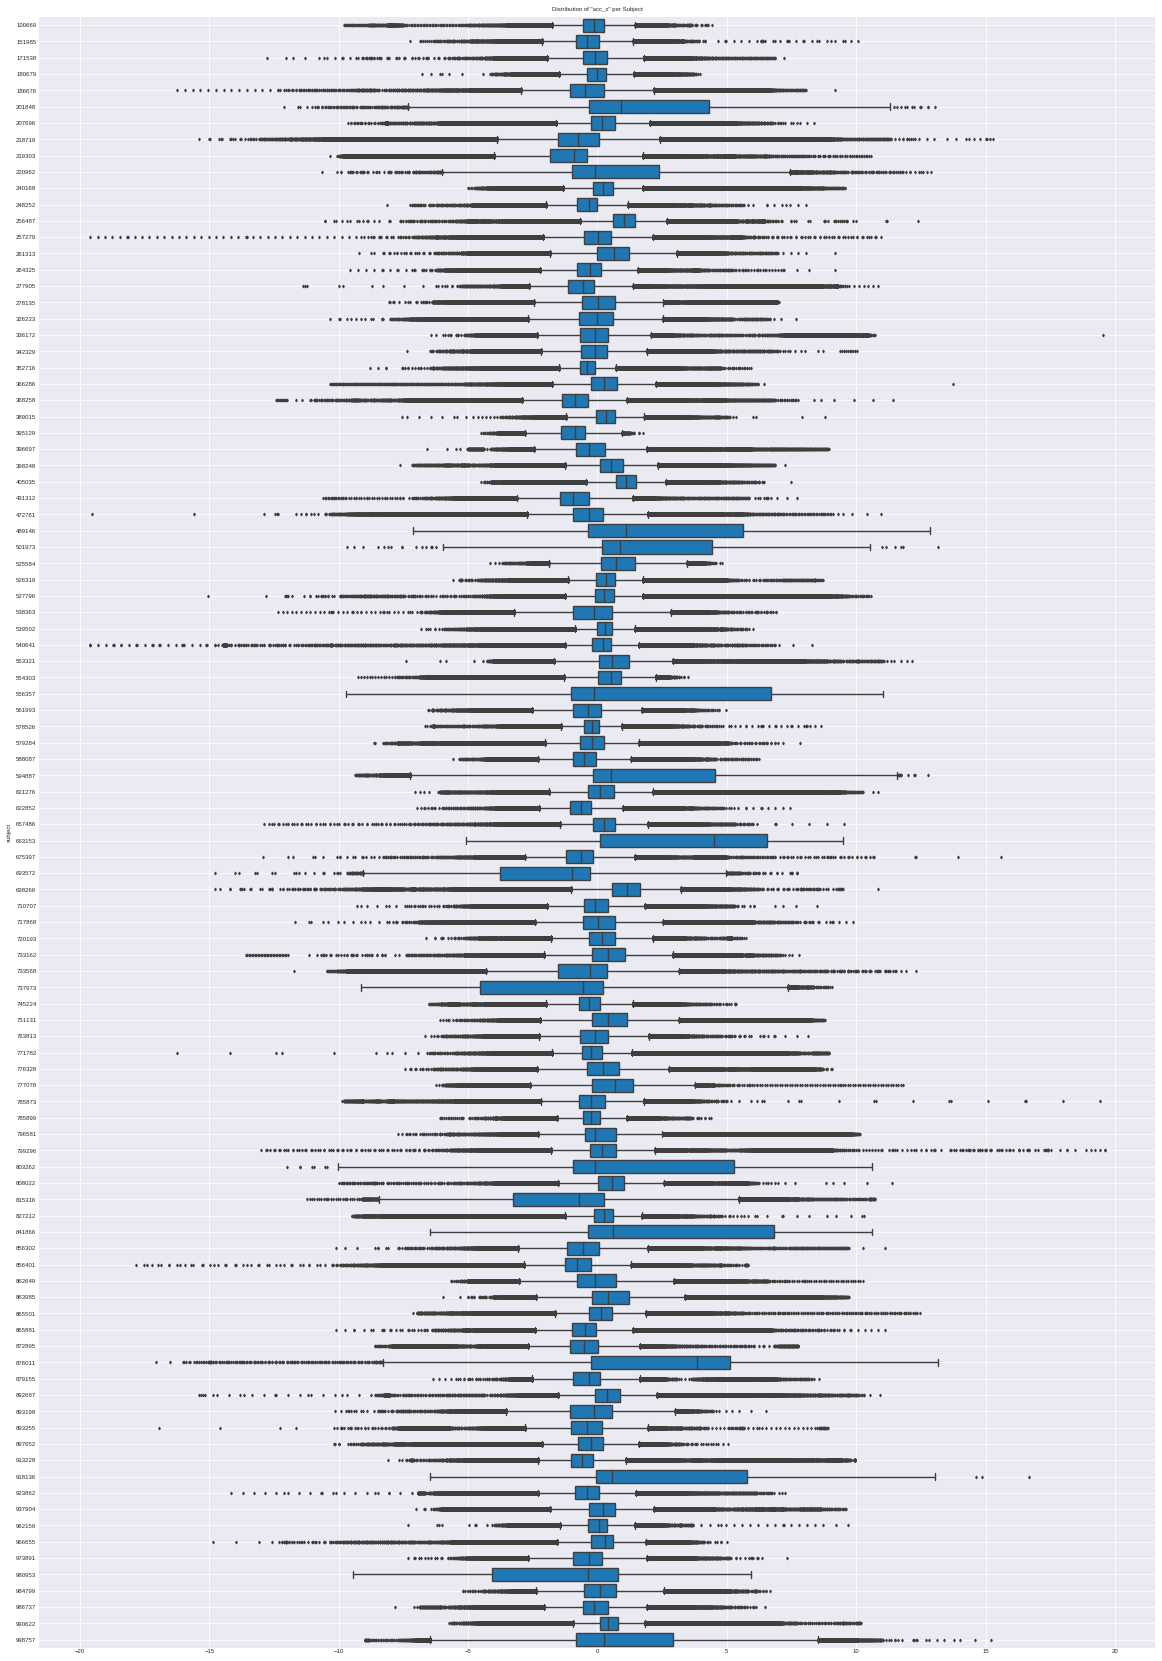

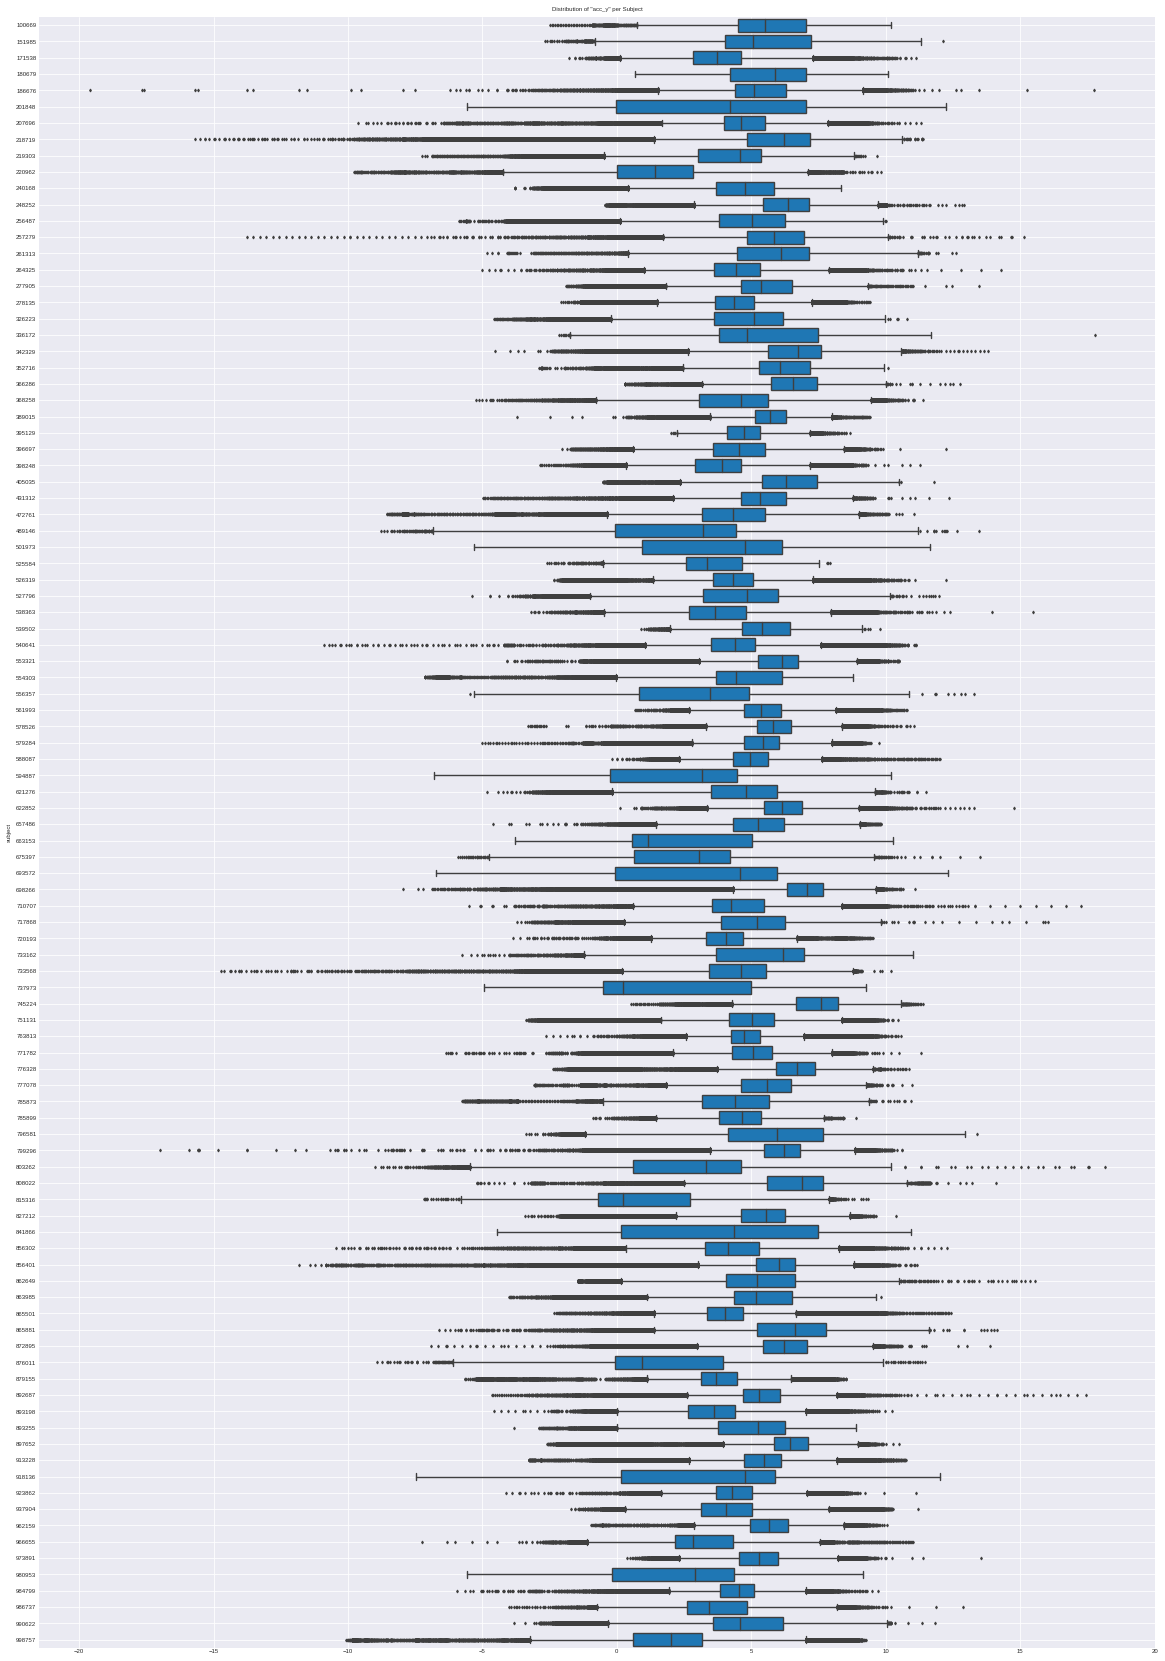

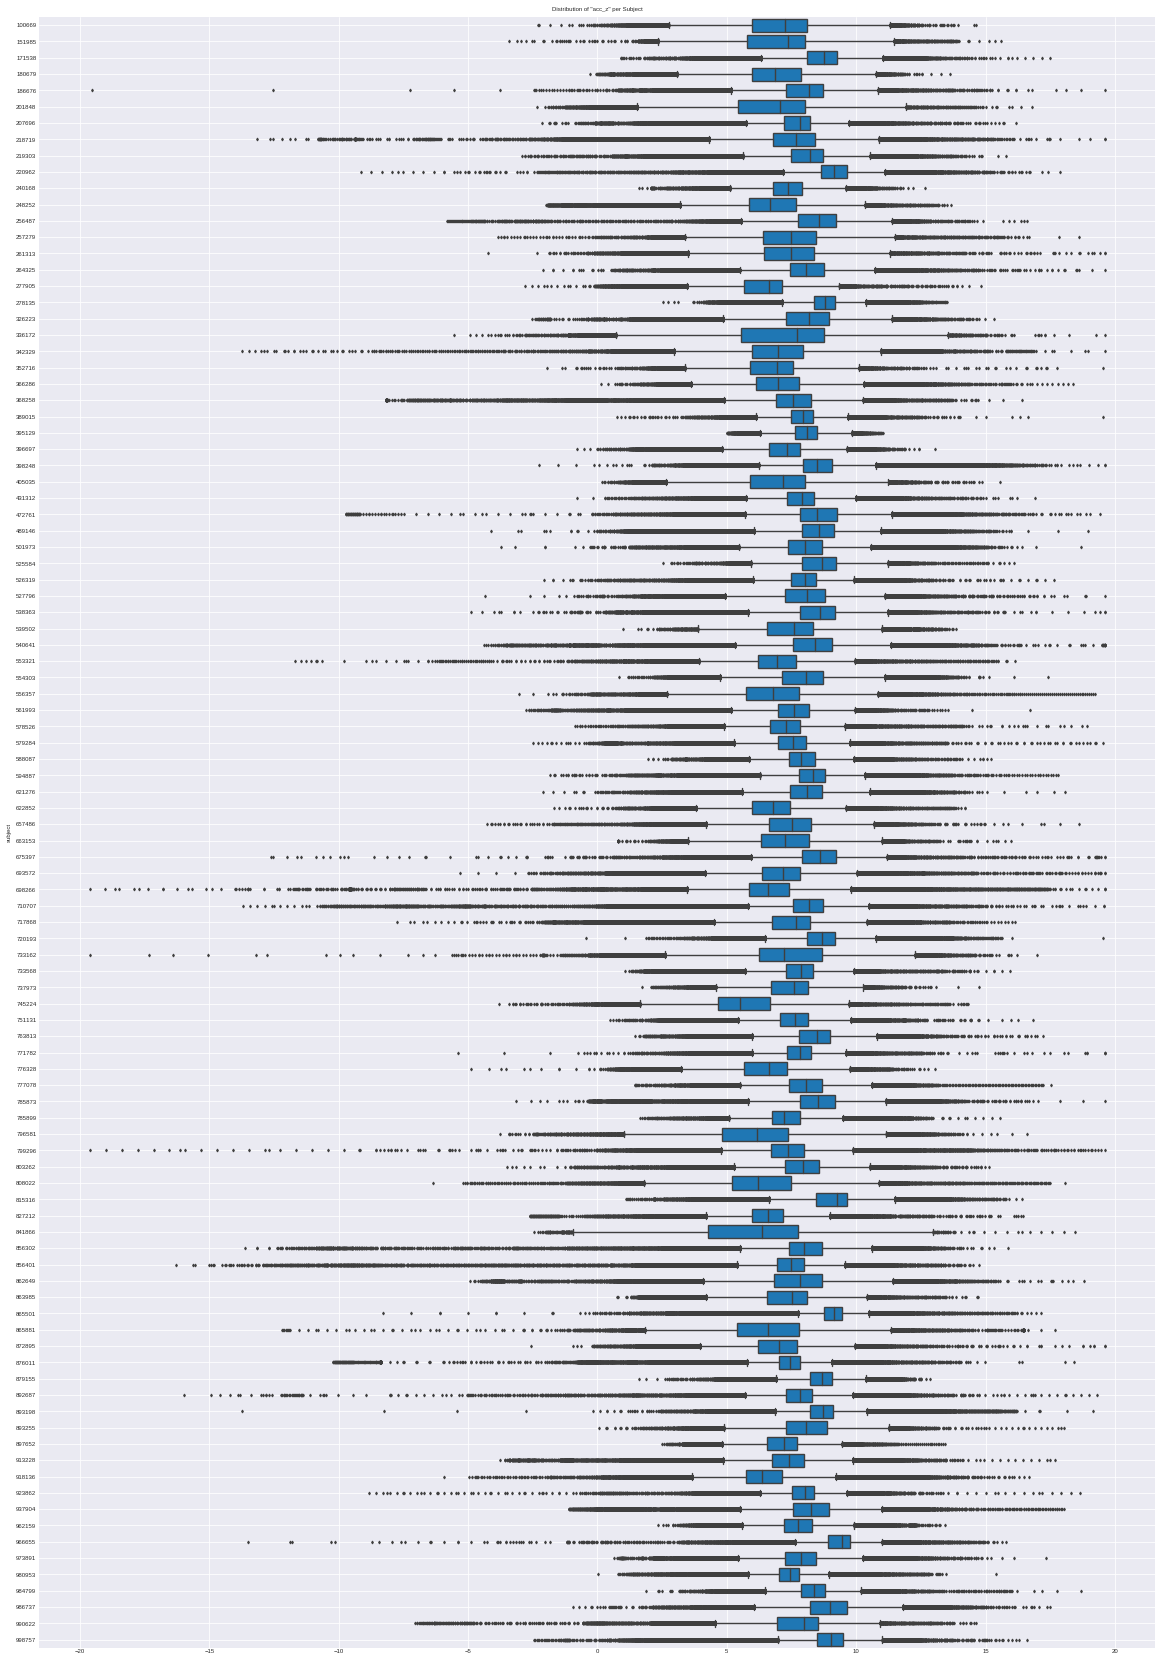

In [56]:
for i, col in enumerate(FEATURE_COLS):
    plt.figure(i, figsize=(20, 30))
    g = sns.boxplot(
        y="subject",
        x=col,
        data=hmog.all,
        orient="h",
        fliersize=2,
        color="tab:blue",
        saturation=1,
    )
    g.set_title(f'Distribution of "{col}" per Subject')
    g.axes.set_xlabel("")
    g.axes.xaxis.grid(True)
    g.axes.yaxis.grid(True)

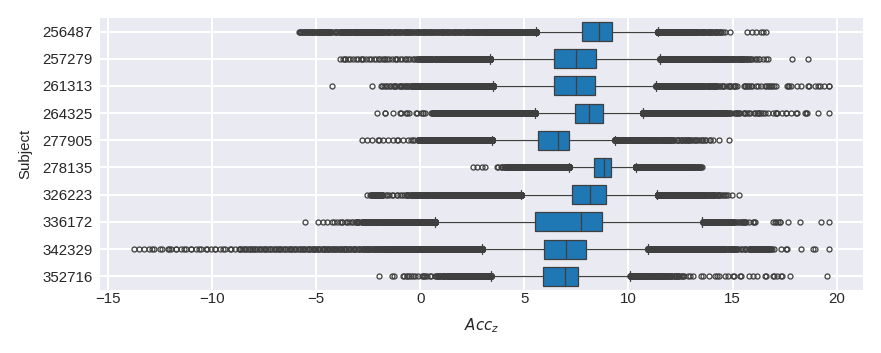

In [57]:
# Partial plot for use in thesis
subjects = [
    "256487",
    "257279",
    "261313",
    "264325",
    "277905",
    "278135",
    "326223",
    "336172",
    "342329",
    "352716",
]
df_temp = hmog.all[hmog.all["subject"].isin(subjects)].copy(deep=True)
df_temp["Subject"] = df_temp["subject"].cat.remove_unused_categories()
df_temp = df_temp.rename(columns={"acc_z": "$Acc_z$"})

plt.figure(dpi=180, figsize=(5.473, 2))
g = sns.boxplot(
    y="Subject",
    x="$Acc_z$",
    data=df_temp,
    orient="h",
    **utils_boxplot_style
)
g.axes.xaxis.grid(True)
g.axes.yaxis.grid(True)

utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-acc-outlier.png")

**Sessions per Subjects**

In [58]:
# Add session number as column
hmog.all["session_number"] = hmog.all["session"].str.rsplit("_", n=1).str[-1].astype("int")
hmog.all.head()

,acc_x,acc_y,acc_z,sys_time,subject,session,task_type,session_number
0,-0.585981,4.196437,7.703344,1400284020080,277905,277905_session_24,6,24
1,-0.004788,3.712210,7.844602,1400284020090,277905,277905_session_24,6,24
2,-0.314239,4.866814,7.767389,1400284020100,277905,277905_session_24,6,24
3,-0.497597,4.911107,7.731974,1400284020110,277905,277905_session_24,6,24
4,-0.680951,4.955399,7.696560,1400284020120,277905,277905_session_24,6,24


In [59]:
df_subjects = (
    hmog.all.groupby("subject").agg({"session": ["nunique", "count"]}).reset_index()
)
df_subjects.columns = ["subject", "sessions", "samples"]
df_subjects["mean_min_per_session"] = df_subjects["samples"] / df_subjects["sessions"] / 100 / 60
df_subjects = df_subjects.sort_values("samples", ascending=False).reset_index(drop=True)
df_subjects.head(3)

,subject,sessions,samples,mean_min_per_session
0,256487,24,2326802,16.158347
1,389015,24,2153042,14.951681
2,856401,24,2028842,14.089181


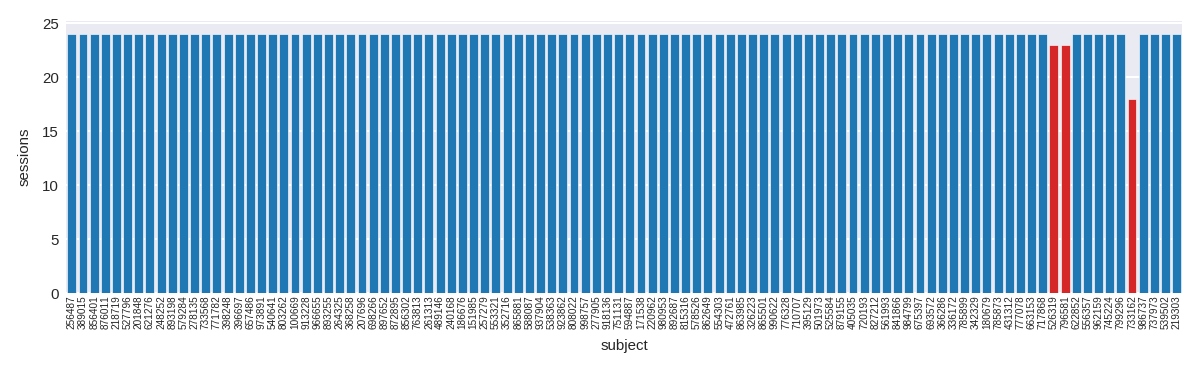

In [60]:
plt.figure(dpi=180, figsize=(8, 2))
clrs = [
    "tab:red" if (x in ("733162", "796581", "526319")) else "tab:blue"
    for x in df_subjects["subject"]
]
sns.barplot(
    x="subject",
    y="sessions",
    data=df_subjects,
    palette=clrs,
    order=df_subjects["subject"],
    saturation=1,
)
plt.xticks(rotation=90, fontsize=4);

**Samples per Subjects**

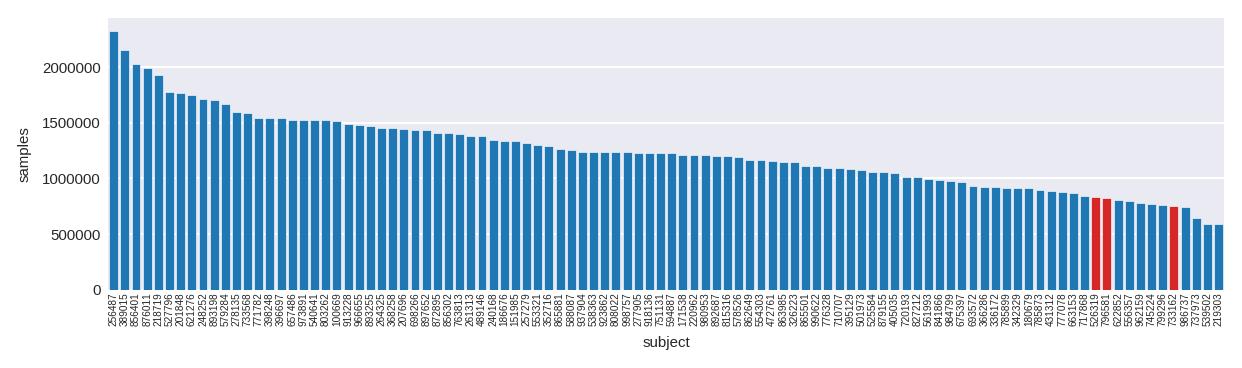

In [61]:
plt.figure(dpi=180, figsize=(8, 2))
clrs = [
    "tab:red" if (x in ("733162", "796581", "526319")) else "tab:blue"
    for x in df_subjects["subject"]
]
sns.barplot(
    x="subject",
    y="samples",
    data=df_subjects,
    palette=clrs,
    order=df_subjects["subject"],
    saturation=1,
)
plt.xticks(rotation=90, fontsize=4);

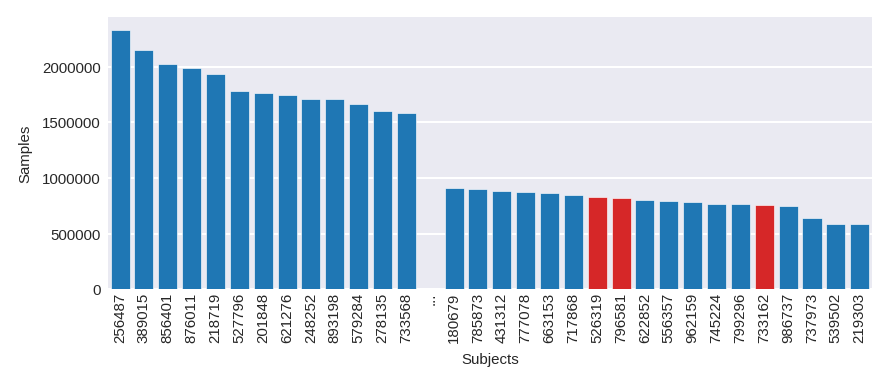

In [62]:
# Partial plot for use in thesis
df_temp = df_subjects
df_temp = pd.concat([df_temp.head(14), df_temp.tail(18)])
df_temp["subject"] = df_temp["subject"].astype(str)
df_temp.loc[df_temp["subject"] == "771782", "samples"] = 0
df_temp.loc[df_temp["subject"] == "771782", "subject"] = "..."


plt.figure(dpi=180, figsize=(5.473, 2))
clrs = [
    "tab:red" if (x in ("733162", "796581", "526319")) else "tab:blue"
    for x in df_temp["subject"]
]

g = sns.barplot(
    x="subject",
    y="samples",
    data=df_temp,
    palette=clrs,
    order=df_temp["subject"],
    saturation=1,
)
g.set_ylabel("Samples")
g.set_xlabel("Subjects")
plt.xticks(rotation=90)

utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-samples-dist.pdf")

**Task Types per Subjects**

In [63]:
# Add session task type as dummies
df_task_dummies = pd.get_dummies(hmog.index['task_type'])
dummy_columns = ["taskid_" + str(col) for col in df_task_dummies.columns]
df_task_dummies.columns = dummy_columns
df_task_types = pd.concat([hmog.index, df_task_dummies], axis=1)

In [64]:
df_tasks = (
    df_task_types.groupby("subject")[dummy_columns].sum()
)

In [65]:
# Mapping according to hmog-docu:
df_tasks.columns = [
    "read + sit",
    "read + walk",
    "write + sit",
    "write + walk",
    "map + sit",
    "map + walk",
]

In [66]:
df_tasks.head()

,read + sit,read + walk,write + sit,write + walk,map + sit,map + walk
subject,,,,,,
100669,4,4,4,4,4,4
151985,4,4,4,4,4,4
171538,4,4,4,4,4,4
180679,4,4,4,4,4,4
186676,4,4,4,4,4,4


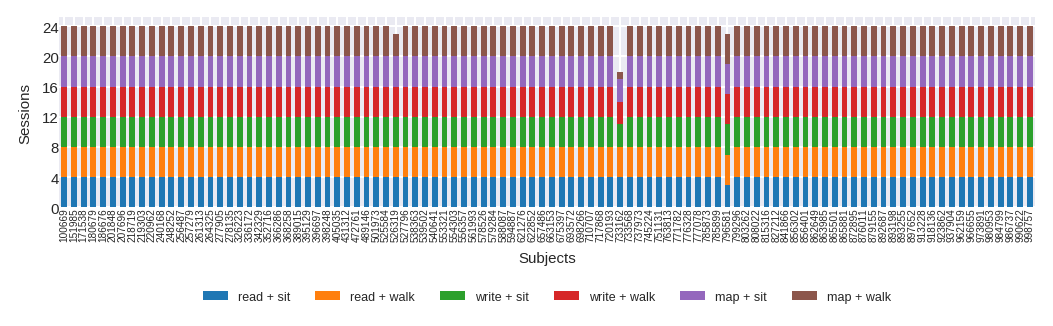

In [67]:
fig = plt.figure(dpi=180, figsize=(7, 1.4))
g = df_tasks.plot(kind="bar", stacked=True, width=0.6, linewidth=0, ax=plt.gca())
g.legend(bbox_to_anchor=(0.5, -0.38), loc="upper center", ncol=6, fontsize=5)
g.tick_params(axis="both", which="major", pad=0)
g.set_xlabel("Subjects", fontsize=6)
g.set_ylabel("Sessions", fontsize=6)
plt.yticks(np.arange(0, 28, 4.0), fontsize=6)
plt.xticks(fontsize=4)
utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-tasks-dist.pdf")

In [68]:
df_tasks[df_tasks < 4].dropna(axis=0, how="all")

,read + sit,read + walk,write + sit,write + walk,map + sit,map + walk
subject,,,,,,
526319,NaN,NaN,NaN,NaN,NaN,3.0
733162,NaN,NaN,3.0,3.0,3.0,1.0
796581,3.0,NaN,NaN,NaN,NaN,NaN


**Interpretation:** The three subjects above have missing sessions (< 4) for certain task types and should be excluded.

### Distributions per Sessions

In [69]:
aggs = ["mean", "std"]
df_session = hmog.all.groupby(["subject", "session_number"]).agg(
    {
        "acc_x": aggs,
        "acc_y": aggs,
        "acc_z": aggs,
        "task_type": ["median", "count"],
    }
)

In [70]:
df_session.columns = ["_".join(col) for col in df_session.columns]
df_session = df_session.rename(columns={"task_type_count": "value_count"}).reset_index()
df_session["Session Duration in Minutes"] = df_session["value_count"] / 100 / 60
df_session["Samples per Session"] = df_session["value_count"]

In [71]:
df_session.head()

,subject,session_number,acc_x_mean,acc_x_std,acc_y_mean,acc_y_std,acc_z_mean,acc_z_std,task_type_median,value_count,Session Duration in Minutes,Samples per Session
0,100669,1,-0.520838,0.939162,6.693929,0.847858,6.247463,0.724431,1,78118,13.019667,78118
1,100669,2,-0.229571,0.407601,7.460647,0.619245,5.514775,0.820172,3,109172,18.195333,109172
2,100669,3,-0.210573,0.452553,6.848979,1.466300,5.977902,1.195907,3,94743,15.790500,94743
3,100669,4,0.013709,0.689000,4.706623,0.729497,7.741555,0.534100,2,51979,8.663167,51979
4,100669,5,-0.038892,0.562523,4.622535,0.624875,7.971410,0.534906,6,37088,6.181333,37088


Histogramm of session duration, for all 2392 sessions


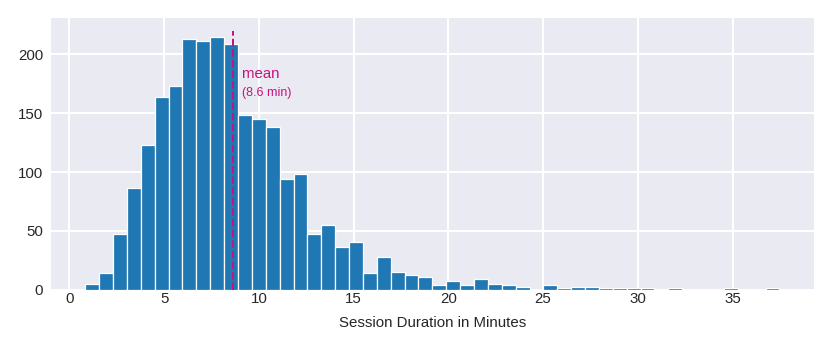

In [72]:
print(f"Histogramm of session duration, for all {len(df_session)} sessions")
mean_duration = df_session["Session Duration in Minutes"].mean()
fig = plt.figure(dpi=180, figsize=(5.473, 2))
g = sns.distplot(
    df_session["Session Duration in Minutes"], kde=False, hist_kws=dict(alpha=1, lw=0.5)
)
g.set_xlabel("Session Duration in Minutes", fontsize=6)
plt.plot(
    [mean_duration, mean_duration], [0, 220], linestyle="dashed", color=MAGENTA, lw=0.8
)
plt.text(
    mean_duration + 0.5,
    180,
    "mean",
    fontsize=6,
    color=MAGENTA,
    horizontalalignment="left",
)
plt.text(
    mean_duration + 0.5,
    165,
    f"({mean_duration:.1f} min)",
    fontsize=5,
    color=MAGENTA,
    horizontalalignment="left",
)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-session-duration.pdf")

Histogramm of session samples, for all 2392 sessions


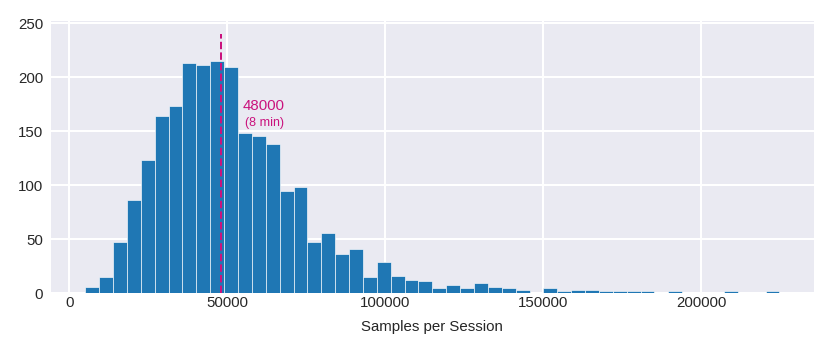

In [85]:
print(f"Histogramm of session samples, for all {len(df_session)} sessions")
fig = plt.figure(dpi=180, figsize=(5.473, 2))
g = sns.distplot(df_session["Samples per Session"], kde=False, hist_kws=dict(alpha=1))
g.set_xlabel("Samples per Session", fontsize=6)
plt.plot([48000, 48000], [0, 240], linestyle="dashed", color=MAGENTA, lw=0.8)
plt.text(68000, 170, "48000", fontsize=6, color=MAGENTA, horizontalalignment="right")
plt.text(68000, 155, "(8 min)", fontsize=5, color=MAGENTA, horizontalalignment="right")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-session-samples.pdf")

In [92]:
df_session[["subject", "session_number", "Session Duration in Minutes"]].sort_values(
    "Session Duration in Minutes"
).head(80)
#df_session[["subject", "session_number", "Session Duration in Minutes"]].describe()

,subject,session_number,Session Duration in Minutes
215,219303,24,0.846500
1340,717868,22,0.913167
213,219303,22,0.970000
907,539502,21,1.166667
208,219303,17,1.504667
2340,986737,21,1.607167
906,539502,20,1.629000
989,556357,7,1.644667
203,219303,12,1.788000
1441,745224,9,1.835500


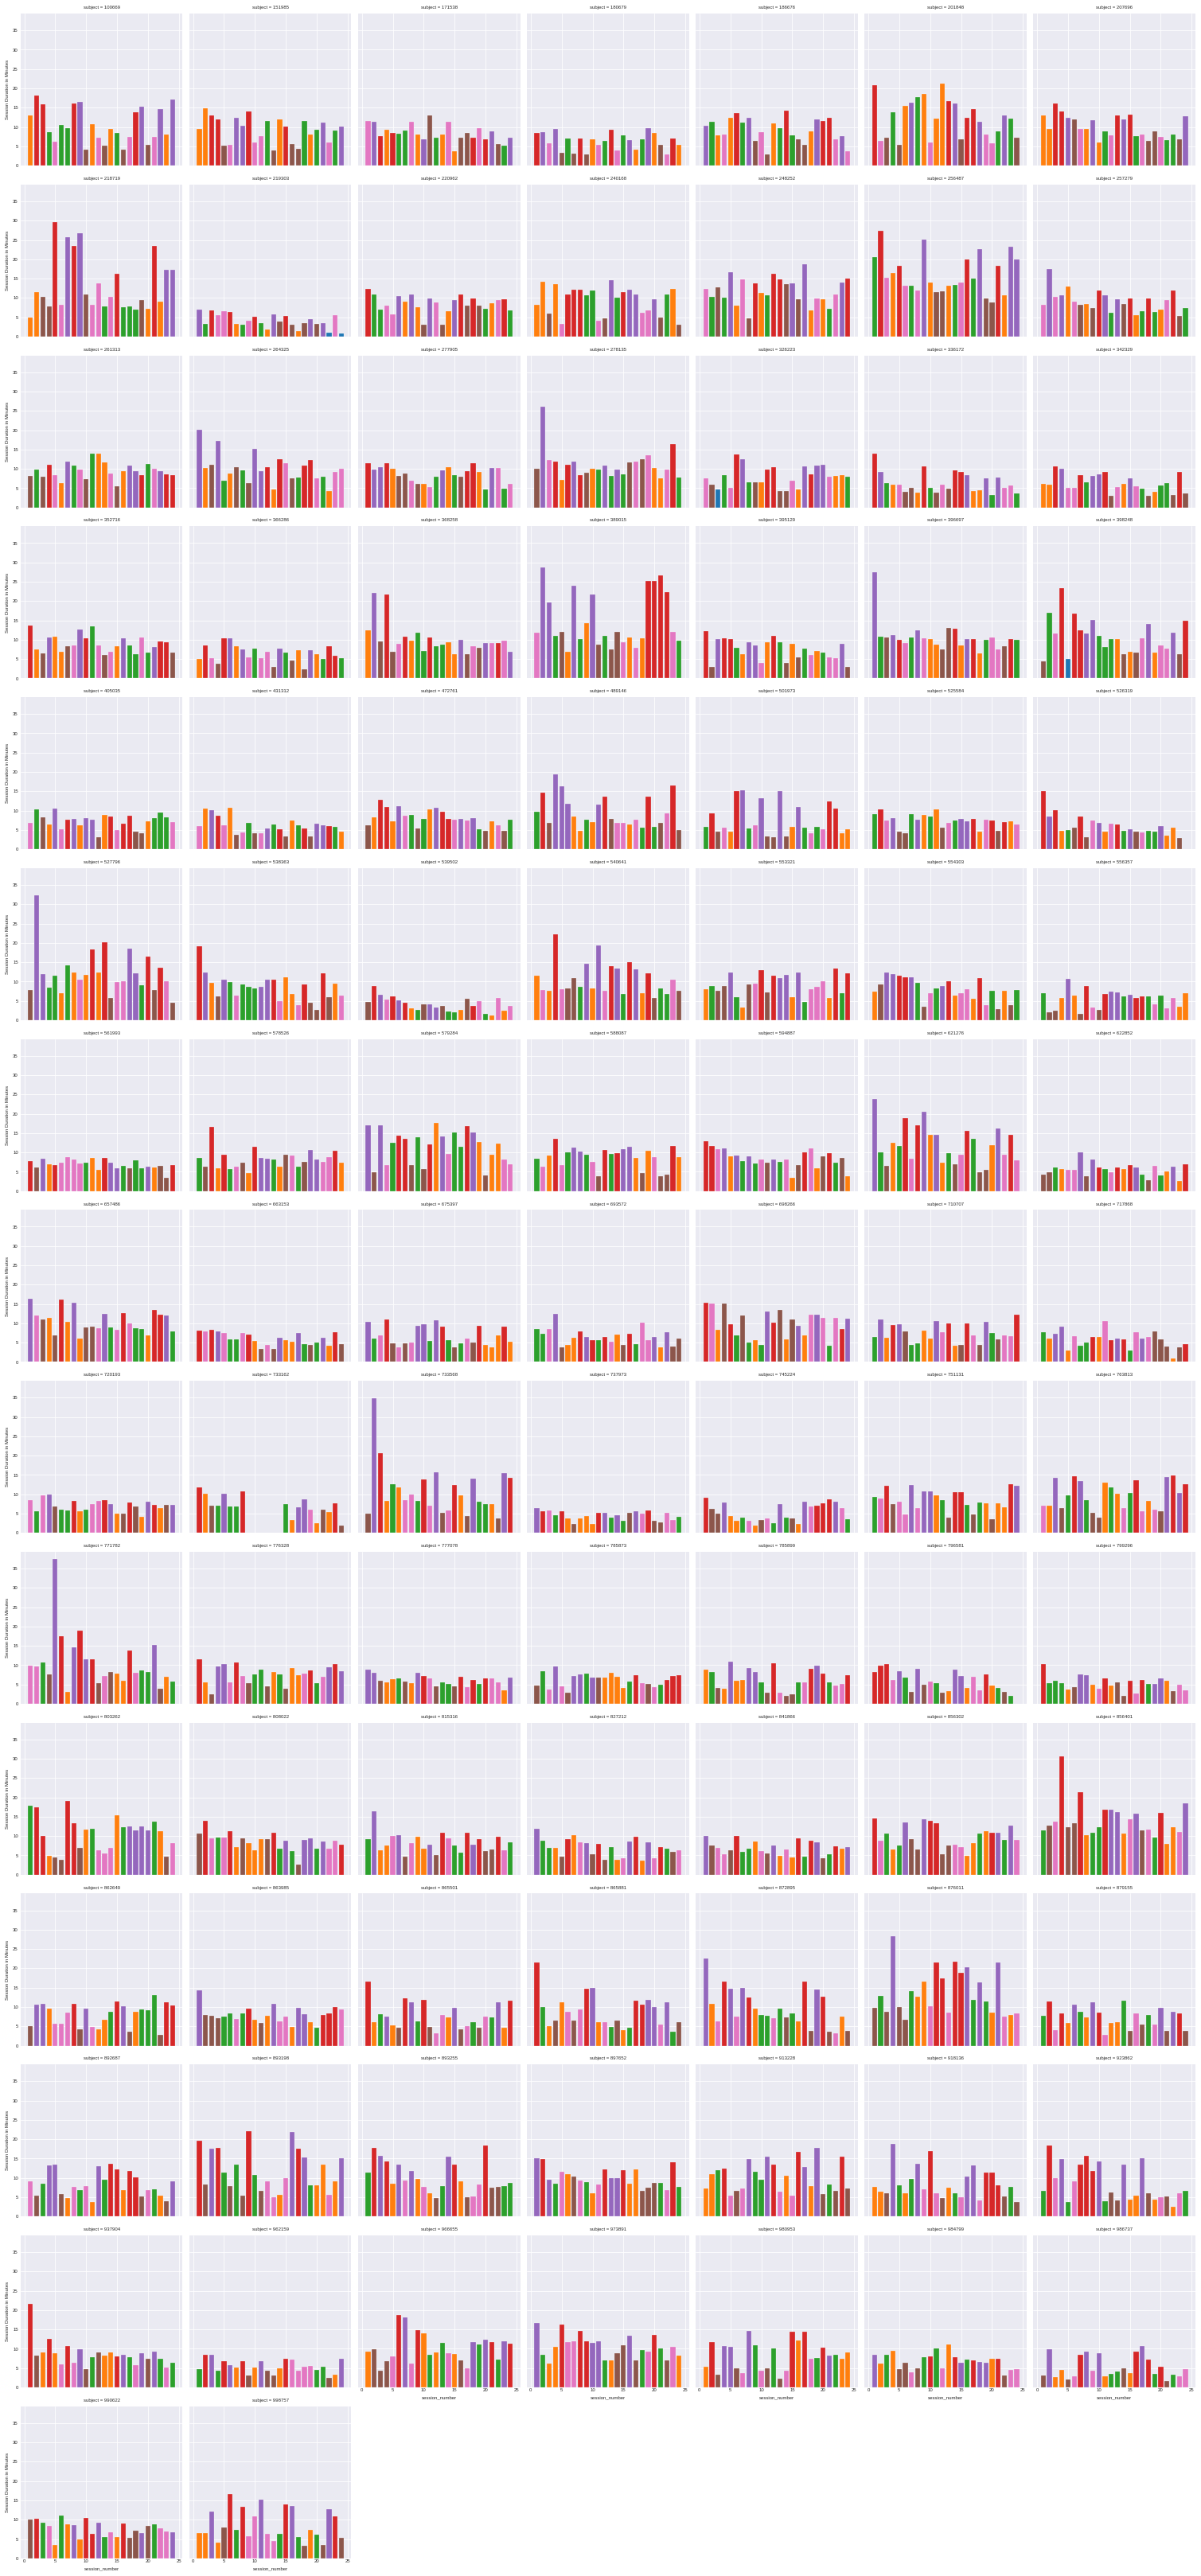

In [101]:
g = sns.FacetGrid(df_session, col="subject", col_wrap=7, hue="task_type_median")
g = g.map(plt.bar, "session_number", "Session Duration in Minutes")

## Correllations

In [102]:
df_session.head()

,subject,session_number,acc_x_mean,acc_x_std,acc_y_mean,acc_y_std,acc_z_mean,acc_z_std,task_type_median,value_count,Session Duration in Minutes,Samples per Session
0,100669,1,-0.520838,0.939162,6.693929,0.847858,6.247463,0.724431,1,78118,13.019667,78118
1,100669,2,-0.229571,0.407601,7.460647,0.619245,5.514775,0.820172,3,109172,18.195333,109172
2,100669,3,-0.210573,0.452553,6.848979,1.466300,5.977902,1.195907,3,94743,15.790500,94743
3,100669,4,0.013709,0.689000,4.706623,0.729497,7.741555,0.534100,2,51979,8.663167,51979
4,100669,5,-0.038892,0.562523,4.622535,0.624875,7.971410,0.534906,6,37088,6.181333,37088


### Sensor Data by Scenario

<Figure size 985.14x985.14 with 0 Axes>

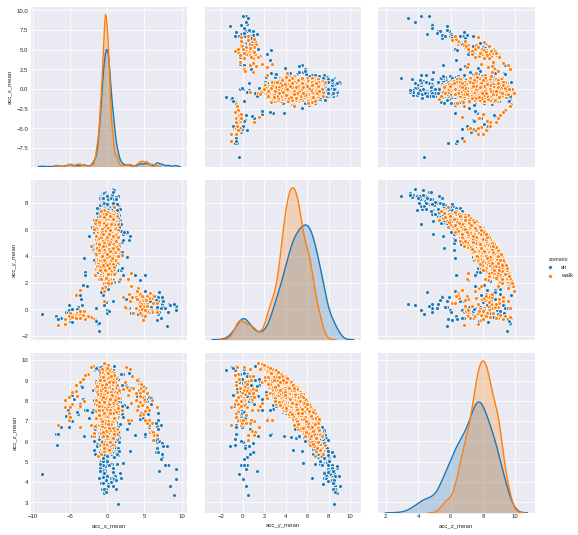

In [103]:
df_temp = df_session[
    [
        "acc_x_mean",
        "acc_y_mean",
        "acc_z_mean",
        "subject",
        "task_type_median",
    ]
].reset_index()
df_temp = df_temp.reset_index(drop="True")
df_temp["scenario"] = np.where(
    df_temp["task_type_median"].isin([2, 4, 6]), "walk", "sit"
)
df_temp["subject"] = df_temp["subject"].astype(str) + " ."  # Workaround bug in seaborn
df_temp = df_temp.drop(columns=["task_type_median", "index"])

fig = plt.figure(dpi=180, figsize=(5.473, 5.473))
sns.pairplot(df_temp, hue="scenario", palette="tab10", plot_kws={"s": 15})
utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-sit-walk.pdf")

### Sensor Data by Subject

<Figure size 985.14x985.14 with 0 Axes>

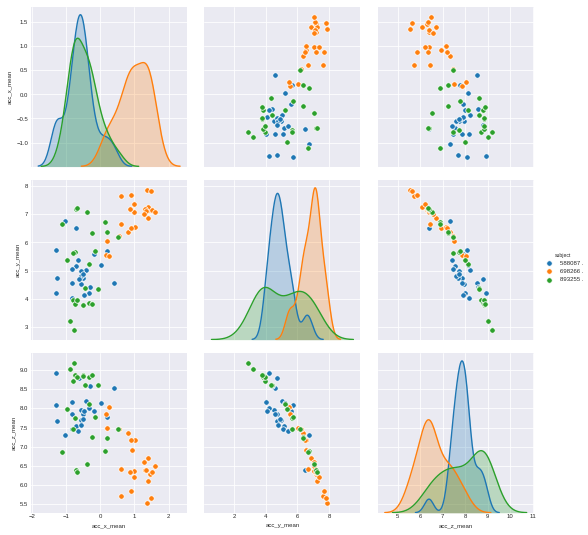

In [104]:
df_temp = df_session[
    [
        "acc_x_mean",
        "acc_y_mean",
        "acc_z_mean",
        "subject",
    ]
].reset_index()
df_temp = df_temp.reset_index(drop=True)
df_temp["subject"] = df_temp["subject"].astype(str) + " ."  # Workaround bug in seaborn
np.random.seed(SEED)
random_subjects = np.random.choice(df_temp["subject"].unique(), size=3)
df_temp = df_temp[df_temp["subject"].isin(list(random_subjects))]
df_temp = df_temp.drop(columns=["index"])

fig = plt.figure(dpi=180, figsize=(5.473, 5.473))
g = sns.pairplot(df_temp, hue="subject", palette="tab10", plot_kws={"s": 30})
utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-three-subjects.pdf")

**Combined partial plot for use in thesis**

In [105]:
# Prepare Data
df_temp = df_session[
    [
        "acc_x_mean",
        "acc_y_mean",
        "acc_z_mean",
        "task_type_median",
        "subject",
    ]
].reset_index()

df_temp["Scenario"] = np.where(
    df_temp["task_type_median"].isin([2, 4, 6]), "walk", "sit"
)
df_temp = df_temp.drop(columns=["task_type_median"])

df_temp = df_temp.rename(
    columns={
        "acc_x_mean": "$mean(Acc_x)$",
        "acc_y_mean": "$mean(Acc_y)$",
        "acc_z_mean": "$mean(Acc_z)$",
        "subject": "Subject",
    }
)
df_temp = df_temp.reset_index(drop=True)
df_temp["Subject"] = df_temp["Subject"].astype(str) + " ."  # Workaround bug in seaborn
np.random.seed(SEED)
random_subjects = np.random.choice(df_temp["Subject"].unique(), size=3)
df_temp = df_temp[df_temp["Subject"].isin(list(random_subjects))]
df_temp = df_temp.drop(columns=["index"])

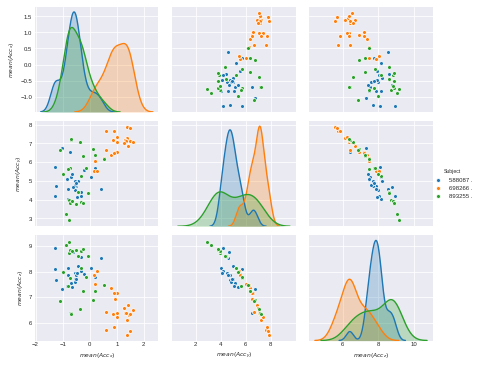

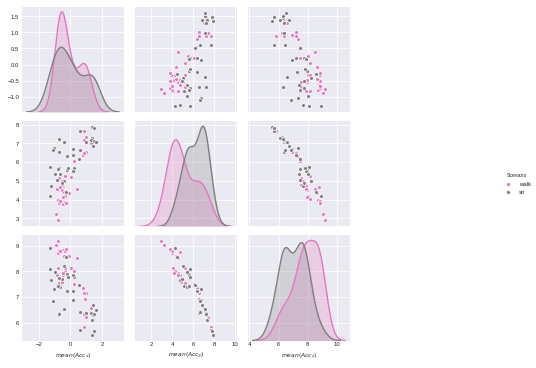

In [106]:
# Plot separately
plt.ioff()
g1 = sns.pairplot(df_temp, hue="Subject", palette=cmap.colors, plot_kws={"s": 15})
g1.fig.set_size_inches(6.5, 5)
g2 = sns.pairplot(df_temp, hue="Scenario", palette=cmap.colors[6:], plot_kws={"s": 15})
for ax in g2.axes.flatten():
    ax.set_ylabel("")
g2.fig.set_size_inches(13, 5)
g2.fig.subplots_adjust(right=0.805)
g2.fig.subplots_adjust(left=0.455)

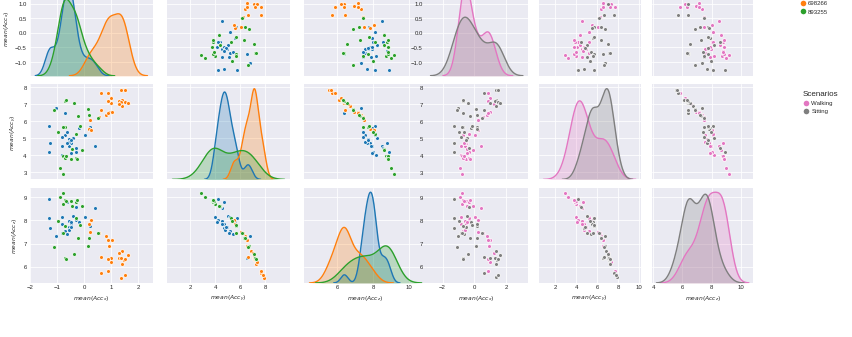

In [107]:
# Combine both plots
f = plt.figure(figsize=(14.3, 5))
for g in [g1, g2]:
    g.fig.subplots_adjust(top=0.99, bottom=0.15)
    for ax in g.fig.axes:
        f._axstack.add(f._make_key(ax), ax)

custom_lines = [
    Line2D([0], [0], color=cmap(0), marker="o", lw=0),
    Line2D([0], [0], color=cmap(1), marker="o", lw=0),
    Line2D([0], [0], color=cmap(2), marker="o", lw=0),
]
f.legend(
    custom_lines,
    ["588087", "698266", "893255"],
    title="Subjects",
    loc="upper right",
    handlelength=0.2,
    bbox_to_anchor=(0.312, 0.5, 0.5, 0.5),
)
custom_lines = [
    Line2D([0], [0], color=cmap(6), marker="o", lw=0),
    Line2D([0], [0], color=cmap(7), marker="o", lw=0),
]
f.legend(
    custom_lines,
    ["Walking ", "Sitting"],
    title="Scenarios",
    loc="upper right",
    handlelength=0.2,
    bbox_to_anchor=(0.319, 0.2, 0.5, 0.5),
)

utils_save_plot(plt, REPORT_PATH / "buech2019-hmog-session-means.pdf")